In [1]:
import torch
import torchvision.transforms as tf
from torchvision import datasets, models
from PIL import Image
from torch.optim import lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
import datetime
from zipfile import ZipFile
import os
import glob
from timeit import default_timer as timer
from typing import Tuple, List, Type, Dict, Any

# Loading data

In [2]:
!wget -P /content/My\ Drive https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip

--2021-12-20 19:14:27--  https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.68.18, 2620:100:6023:18::a27d:4312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.68.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/vgqpz2f1lolxmlv/data.zip [following]
--2021-12-20 19:14:28--  https://www.dropbox.com/s/raw/vgqpz2f1lolxmlv/data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2cf97075ffec4e29805bff1ae4.dl.dropboxusercontent.com/cd/0/inline/BcN_SRmRgqkX_2kX74pcw4JGaneY9DNkI9Bu57VJZxG5R_CSAbegU_1HY4-gxpsfSLduGc-GYawW_Aroc-YaLoWNOvT2gabgMnEc4MzJkv-sMwr6Y6h7ZlM5QK4_8uRT4j-PpipZmlEh9INHoTMpZc76/file# [following]
--2021-12-20 19:14:28--  https://uc2cf97075ffec4e29805bff1ae4.dl.dropboxusercontent.com/cd/0/inline/BcN_SRmRgqkX_2kX74pcw4JGaneY9DNkI9Bu57VJZxG5R_CSAbegU_1HY4-gxpsfSLduGc-GYawW_Aroc-YaLoWNOvT2gabgMnE

In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

path = "/content/My Drive/data.zip"
z = ZipFile(path, 'r')
z.extractall(r"/content/My Drive/")
z.close()

# Creating dataset with torch.Dataset

In [5]:
class DogsDataset(torch.utils.data.Dataset):
    
    def __init__(self, root_dir, transforms = None):
        
        super().__init__()
        self.transforms = transforms

        file_list = glob.glob(root_dir + "*")

        self.data = []
        for class_path in file_list:
            class_name = class_path.split("/")[-1]
            for img_path in glob.glob(class_path + "/*.jpeg"):
                self.data.append([img_path, class_name])
        
    def __len__(self):
        
        return len(self.data)
        
    def __getitem__(self, index):
        
        img_path, class_name = self.data[index]        
        img = plt.imread(img_path)        
        label = torch.tensor(int(class_name))
        
        if self.transforms:
            masked_image = self.transforms(img)
            
        return (masked_image, label)

I decided to do some harmless augmentations, also in the process of training tried Normalize, but it did not significantly affect the result.

In [6]:
transforms = tf.Compose([tf.ToPILImage(), 
                         tf.Resize([256, 256]),
        tf.RandomRotation(degrees=10),
        tf.RandomHorizontalFlip(),
        tf.ToTensor(),
    ])

In [7]:
DogsData = DogsDataset(root_dir = "/content/My Drive/data/train/", transforms = transforms)

Let's see if the dataset is built correctly.


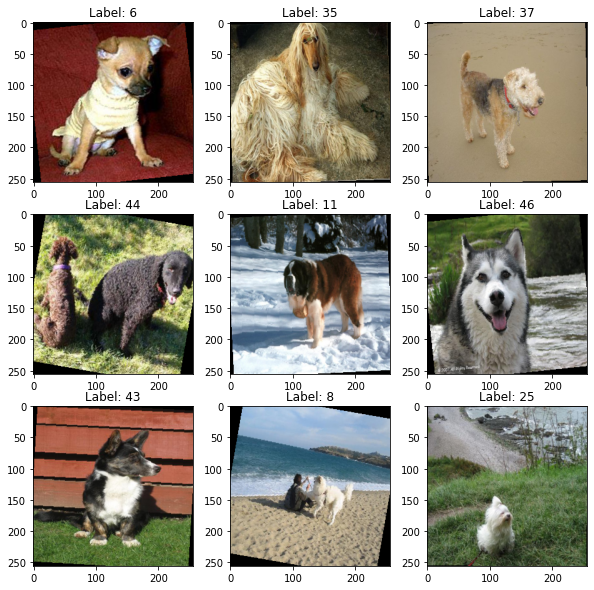

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        sample, label = DogsData[i*695+j*475]
        ax.imshow(sample.cpu().numpy().transpose(1, 2, 0))
        ax.set_title('Label: {}'.format(int(label)))

In [9]:
def train_single_epoch(model : torch.nn.Module,
                       optimizer : torch.optim.Optimizer,
                       loss_function : torch.nn.Module,
                       data_loader : torch.utils.data.DataLoader):
    
    model.train()
    loss_total = 0
    batch_size = 0

    for data in data_loader:
        batch_size += 1
        
        X, y = data
        X, y = X.to(device), y.to(device)
        
        optimizer.zero_grad()
        output = model(X)
        
        loss = loss_function(output, y)
        loss_total += loss
        loss.backward()
        
        optimizer.step()
    
    loss_avg = loss_total / batch_size
    
    return loss_avg

In [10]:
@torch.no_grad()
def validate_single_epoch(model: torch.nn.Module,
                          loss_function: torch.nn.Module, 
                          data_loader: torch.utils.data.DataLoader):
    
    model.eval()
    loss_total = 0
    accuracy_total = 0
    accuracy_correct = 0
    batch_size = 0
    
    for data in data_loader:
        batch_size += 1
        
        X, y = data
        X, y = X.to(device), y.to(device)
        
        output = model(X)
        
        loss = loss_function(output, y)
        loss_total += loss
        
        y_pred = output.argmax(dim = 1, keepdim = True).to(device)
        accuracy_correct += int(torch.sum(y_pred == y))
        accuracy_total += (y_pred == y.view_as(y_pred)).cpu().numpy().mean()
        
    loss_avg = loss_total / batch_size
    accuracy_avg = 100.0 * accuracy_total / batch_size
    
    return {'loss' : loss_avg, 'accuracy' : accuracy_avg}

In [11]:
def train_model(model: torch.nn.Module, 
                train_dataset: torch.utils.data.Dataset,
                valid_dataset: torch.utils.data.Dataset,
                loss_function: torch.nn.Module = torch.nn.CrossEntropyLoss(),
                optimizer_class: Type[torch.optim.Optimizer] = torch.optim,
                optimizer_params: Dict = {},
                initial_lr = 0.01,
                lr_scheduler_class: Any = torch.optim.lr_scheduler.ReduceLROnPlateau,
                lr_scheduler_params: Dict = {},
                batch_size = 64,
                max_epochs = 1000,
                early_stopping_patience = 20, 
                best_model_root = './best_model.pth'):
    
    
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr, **optimizer_params)
    lr_scheduler = lr_scheduler_class(optimizer, **lr_scheduler_params)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size, pin_memory = True, num_workers = 1)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, num_workers = 1)

    best_valid_loss = None
    best_epoch = None
    loss_list = {'train' : list(), 'valid' : list()}
    accuracy_list = list()
    
    for epoch in range(max_epochs):
        
        print(f'Epoch {epoch}')
        
        start = timer()
        
        train_loss = train_single_epoch(model, optimizer, loss_function, train_loader)
        
        # Evaluate perfomance on the training set
        loss_list['train'].append(train_loss)
        
        # Evaluate perfomance on the cross-validation set
        valid_metrics = validate_single_epoch(model, loss_function, valid_loader)
        loss_list['valid'].append(valid_metrics['loss'])
        accuracy_list.append(valid_metrics['accuracy'])
        
        print('time:', timer() - start)
        print(f'Validation metrics: \n{valid_metrics}')

        lr_scheduler.step(valid_metrics['loss'])
        
        if best_valid_loss is None or best_valid_loss > valid_metrics['loss']:
            print(f'-----Best model yet, saving-----')
            best_valid_loss = valid_metrics['loss']
            best_epoch = epoch
            torch.save(model, best_model_root)
            
        if epoch - best_epoch > early_stopping_patience:
            print('Early stopping triggered')
            return

## Create a model

In [12]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print('Using GPU', f'({torch.cuda.get_device_name()})')
else:
    device = torch.device('cpu')
    print('Using CPU')

Using GPU (Tesla K80)


I decided to use fine-tuning to build the model, since it is a great option for the specifics of our task with data similar to ImageNet.Before I used resnet-50, I tried the same thing with resnet-18, but the result was significantly lower, about `accuracy` = 0.86

In [13]:
model = models.resnext50_32x4d(pretrained=True)


for param in model.parameters():
    param.requires_grad = False

     
num_ftrs = model.fc.in_features
model.fc = torch.nn.Sequential(
            torch.nn.Linear(num_ftrs, 50)
        )

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

In [14]:
model.to(device)

print(model)
print('Total number of trainable parameters', 
      sum(p.numel() for p in model.parameters() if p.requires_grad))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [15]:
train_dataset, valid_dataset = torch.utils.data.random_split(DogsData, [len(DogsData) - 1500, 1500])

# Train Stage

In [16]:
train_model(model, 
            train_dataset=train_dataset, 
            valid_dataset=valid_dataset, 
            loss_function=torch.nn.CrossEntropyLoss(), 
            initial_lr=0.001, max_epochs = 10, batch_size = 128)

Epoch 0
time: 94.69093789599998
Validation metrics: 
{'loss': tensor(0.6088, device='cuda:0'), 'accuracy': 91.20244565217392}
-----Best model yet, saving-----
Epoch 1
time: 94.165656394
Validation metrics: 
{'loss': tensor(0.3645, device='cuda:0'), 'accuracy': 92.59510869565219}
-----Best model yet, saving-----
Epoch 2
time: 94.31723179199997
Validation metrics: 
{'loss': tensor(0.2980, device='cuda:0'), 'accuracy': 92.81589673913044}
-----Best model yet, saving-----
Epoch 3
time: 94.21343478399996
Validation metrics: 
{'loss': tensor(0.2520, device='cuda:0'), 'accuracy': 94.03872282608695}
-----Best model yet, saving-----
Epoch 4
time: 94.19910443599997
Validation metrics: 
{'loss': tensor(0.2446, device='cuda:0'), 'accuracy': 93.80661231884058}
-----Best model yet, saving-----
Epoch 5
time: 94.06124197200006
Validation metrics: 
{'loss': tensor(0.2275, device='cuda:0'), 'accuracy': 93.46693840579711}
-----Best model yet, saving-----
Epoch 6
time: 94.206499291
Validation metrics: 
{'l

# Testing Stage

In [17]:
class DogsDatasetTest(torch.utils.data.Dataset):
    
    def __init__(self, root_dir, transforms = None):
        
        super().__init__()
        self.transforms = transforms
        
        file_list = glob.glob(root_dir + "*")
        # print(file_list)

        self.data = []
        for img_path in file_list:
          class_name = img_path.split("/")[-1]
          # print(img_path, '-', class_name)
          self.data.append([img_path, class_name])
        
    def __len__(self):
        
        return len(self.data)
        
    def __getitem__(self, index):
        
        img_path, class_name = self.data[index]        
        img = plt.imread(img_path)        

        if self.transforms:
            masked_image = self.transforms(img)
            
        return (masked_image, class_name)

In [18]:
transforms = tf.Compose([tf.ToPILImage(), 
                         tf.Resize([256, 256]),
                        tf.ToTensor()
    ])

In [19]:
DogsDataTest = DogsDatasetTest(root_dir = '/content/My Drive/data/test/', transforms = transforms)

In [20]:
test_loader = torch.utils.data.DataLoader(DogsDataTest, shuffle=False, batch_size=128)

Let's choose best model from train process.

In [21]:
model = torch.load('./best_model.pth')

In [22]:
model.eval()
fn_list = []
pred_list = []
for x, fn in test_loader:
    with torch.no_grad():
        x = x.to(device)
        output = model(x)
        pred = torch.argmax(output, dim=1)
        fn_list += [n[:-4] for n in fn]
        pred_list += [p.item() for p in pred]

submission = pd.DataFrame({"jpeg":fn_list, "label":pred_list})
submission.to_csv('dogs_eval.csv', index=False)

**Small conclusion**: In this task I tried the trasnfer learning method of fine-tuning. I took various pre-trained models, froze the weights, replaced them with a head, and tested them on a dataset with a dog classification. This method is very useful because you end up with a really strong model in your hands, which would be hard to replace on your own.